# Libraries

In [53]:
#!pip install -q transformers==4.47.1
#!pip install -q datasets==3.2.0
#!pip install -q torch==2.5.1
#!pip install -q lm-eval==0.4.7

In [54]:
import logging
import math
import os
import sys
import shutil
from copy import deepcopy

import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import os

# Model Loading


In [55]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: {device}")


Using device: {device}


In [56]:
torch.cuda.empty_cache()
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   4726 MiB |  15732 MiB |  48431 MiB |  43704 MiB |\n|       from large pool |   4726 MiB |  15725 MiB |  31214 MiB |  26488 MiB |\n|       from small pool |      0 MiB |      9 MiB |  17216 MiB |  17216 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   4726 MiB |  15732 MiB |  48431 MiB |  43704 MiB |\n|       from large pool |   4726 MiB |  15725 MiB |

In [ ]:
model_name = 'meta-llama/Llama-3.2-1B'
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [59]:
# structure of the model
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

# Prunning


## Support functions

In [60]:
def measure_unpruned_layer_importances(pruned_model, tokenizer, input_text):
    """
    Measures and returns importance scores for all unpruned (non-bypassed) layers.
    """
    # PREPARATION
    """
    set the model to evaluation mode to ensure that no gradients
    are computed during the forward pass.
    """
    pruned_model.eval()
    device = next(pruned_model.parameters()).device

    """
    The provided input text (input_text) is tokenized into tensors
    suitable for processing by the model.
    """
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    """This will hold tuples of (layer_idx, importance_score)"""
    importance_scores = []

    # IDENTIFY UNPRUNED LAYERS & CREATING HOOKS
    """
    We'll register hooks for only layers that are NOT in drop_attn_list
    The list of attention layers that have already been pruned,
    is stored in a variable in the model's config: pruned_model.config.drop_attn_list.
    """
    unpruned_layer_indices = [
        idx for idx in range(len(pruned_model.model.layers))
        if idx not in pruned_model.config.drop_attn_list
    ]

    """
    Temporary storage for each layer's input/output
    We'll store them by layer index
    """
    layer_inputs = {}
    layer_outputs = {}

    """
    Create 2 hooks to capture the input and the output of the layers.
    These hooks store the inputs and outputs in dictionaries
    (layer_inputs and layer_outputs) for later analysis
    """
    #Allows capture the input to the query projection (q_proj)
    def q_proj_input_hook(layer_idx):
        def _hook(module, module_input):
            # module_input can be a tuple depending on PyTorch version
            inp = module_input[0] if isinstance(module_input, tuple) else module_input
            layer_inputs[layer_idx] = inp.detach().clone()
        return _hook

    # Allows capture the output from the output projection (o_proj)
    def o_proj_output_hook(layer_idx):
        def _hook(module, module_input, module_output):
            out = module_output[0] if isinstance(module_output, tuple) else module_output
            layer_outputs[layer_idx] = out.detach().clone()
        return _hook

    # Register hooks for each unpruned layer
    handles = []
    for idx in unpruned_layer_indices:
        layer = pruned_model.model.layers[idx]
        handles.append(layer.self_attn.q_proj.register_forward_pre_hook(q_proj_input_hook(idx)))
        handles.append(layer.self_attn.o_proj.register_forward_hook(o_proj_output_hook(idx)))

    # FORWARD PASS
    """
    Single forward pass (no gradient needed)
    A single forward pass is performed on the input text.
    During this pass, the hooks capture the inputs and outputs of the unpruned layers.
    This step is done with torch.no_grad(),
    ensuring no gradients are calculated, which saves memory and computation.
    """
    with torch.no_grad():
        _ = pruned_model(**inputs)

    """
    The hooks are removed after the forward pass
    to avoid memory leaks or interference with subsequent operations.
    """
    for h in handles:
        h.remove()


    #COMPUTE IMPORTANCE SCORES
    """
    For each unpruned layer, the inputs and outputs are flattened into vectors for comparison.

    Cosine Similarity: The similarity between the input and output vectors is
    computed using cosine similarity. Layers with outputs that are very similar
    to their inputs likely contribute less to the model’s overall computation.

    Importance Score: The importance score for each layer is calculated as 1−similarity
    A higher score indicates that the layer transforms its input significantly
    and is therefore more important to the model's function.
    """
    for idx in unpruned_layer_indices:
        if idx in layer_inputs and idx in layer_outputs:
            inp = layer_inputs[idx]
            out = layer_outputs[idx]

            inp_flat = inp.view(inp.size(0), -1)
            out_flat = out.view(out.size(0), -1)

            similarity = F.cosine_similarity(inp_flat, out_flat, dim=1).mean().item()
            importance_score = 1 - similarity
            importance_scores.append((idx, importance_score))

            print(f"[Iterative] Layer {idx} importance score: {importance_score:.4f}")

    """A list of tuples is returned, where each tuple contains the layer index
    and its calculated importance score."""
    return importance_scores

In [61]:
def bypass_single_layer(pruned_model, layer_idx):
    """
    Modifies the specified layer's forward method so that attention is bypassed.
    """
    layer = pruned_model.model.layers[layer_idx]
    # Store the original forward.
    if not hasattr(layer.self_attn, '_original_forward'):
        layer.self_attn._original_forward = layer.self_attn.forward

    # A new forward that checks whether to bypass
    def new_attention_forward(self, hidden_states, attention_mask=None, position_ids=None,
                              past_key_value=None, output_attentions=False, use_cache=False,
                              **kwargs):
        # If this layer is in drop_attn_list, bypass
        if getattr(self, 'layer_idx', -1) in pruned_model.config.drop_attn_list:
            return hidden_states, None, None
        # Otherwise, use the original forward
        return self._original_forward(hidden_states, attention_mask, position_ids,
                                      past_key_value, output_attentions, use_cache, **kwargs)

    # Set the layer index and forward
    layer.self_attn.layer_idx = layer_idx
    layer.self_attn.forward = new_attention_forward.__get__(layer.self_attn, type(layer.self_attn))


In [62]:
def iterative_pruning(model, tokenizer, input_text, num_layers_to_prune):
    """
    Iteratively:
      1) Measures importance of unpruned layers,
      2) Prunes (bypasses) the least important layer,
      3) Repeats until num_layers_to_prune layers are pruned.
    """
    # Create a copy of the model so we don't modify the original
    pruned_model = deepcopy(model)

    # Make sure we have a list of pruned layers in config
    pruned_model.config.drop_attn_list = []

    total_layers = len(pruned_model.model.layers)
    print(f"Total layers: {total_layers}")

    for step in range(num_layers_to_prune):
        print(f"\n--- Iteration {step + 1} of {num_layers_to_prune} ---")

        # 1) Measure importance scores for all unpruned layers
        importance_scores = measure_unpruned_layer_importances(pruned_model, tokenizer, input_text)
        if not importance_scores:
            print("No unpruned layers found or no importance scores computed.")
            break

        # 2) Pick layer with the lowest importance
        layer_to_bypass, min_score = min(importance_scores, key=lambda x: x[1])

        # 3) Bypass that layer
        pruned_model.config.drop_attn_list.append(layer_to_bypass)
        bypass_single_layer(pruned_model, layer_to_bypass)

        print(f"Bypassing layer {layer_to_bypass} with importance score {min_score:.4f}")
        print(f"Current bypass list: {pruned_model.config.drop_attn_list}")

    print(f"\nFinal bypassed layers: {sorted(pruned_model.config.drop_attn_list)}")
    print(f"Number of bypassed layers: {len(pruned_model.config.drop_attn_list)}")

    return pruned_model

## Prunning the model

In [ ]:
pruned_model = iterative_pruning(
      model,
      tokenizer,
       "Hi I'm a sample text, use to calculate the cosine difference between input and output.",
      num_layers_to_prune=2
)

Total layers: 16

--- Iteration 1 of 2 ---
[Iterative] Layer 0 importance score: 1.1235
[Iterative] Layer 1 importance score: 0.9898
[Iterative] Layer 2 importance score: 0.9640
[Iterative] Layer 3 importance score: 1.0608
[Iterative] Layer 4 importance score: 1.0264
[Iterative] Layer 5 importance score: 1.0813
[Iterative] Layer 6 importance score: 1.1420
[Iterative] Layer 7 importance score: 1.0772
[Iterative] Layer 8 importance score: 1.1254
[Iterative] Layer 9 importance score: 0.9874
[Iterative] Layer 10 importance score: 1.1360
[Iterative] Layer 11 importance score: 0.8226
[Iterative] Layer 12 importance score: 0.7812
[Iterative] Layer 13 importance score: 0.7732
[Iterative] Layer 14 importance score: 0.7437
[Iterative] Layer 15 importance score: 1.1173
Bypassing layer 14 with importance score 0.7437
Current bypass list: [14]

--- Iteration 2 of 2 ---
[Iterative] Layer 0 importance score: 1.1235
[Iterative] Layer 1 importance score: 0.9898
[Iterative] Layer 2 importance score: 0.9

# Test the Model

In [65]:
import time

def get_output(prompt, model=model, tokenizer=tokenizer, num_runs=1, max_length=50):
    total_time = 0
    generated_outputs = []

    for run in range(num_runs):
        # Start timing
        start_time = time.time()

        # Tokenization time
        token_start = time.time()
        inputs = tokenizer(prompt, return_tensors='pt').to(device)
        token_time = time.time() - token_start

        # Generation time
        gen_start = time.time()
        outputs = model.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_length,
            num_return_sequences=1,
            pad_token_id=tokenizer.pad_token_id,
            temperature=None,
            top_p=None,
            do_sample=False,  # Disable sampling
            num_beams=5,      # Use beam search
            early_stopping=True,  # Stop when end-of-sequence token is generated
            no_repeat_ngram_size=2  # Prevent repetition of 2-grams
        )
        gen_time = time.time() - gen_start

        # Decoding time
        decode_start = time.time()
        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        decode_time = time.time() - decode_start

        # Total time for this run
        total_time += time.time() - start_time
        generated_outputs.append(generated)

        # Measure memory usage
        memory_allocated = torch.cuda.memory_allocated() / (1024 ** 2)  # In MB
        memory_reserved = torch.cuda.memory_reserved() / (1024 ** 2)  # In MB

        print(f"Memory Allocated: {memory_allocated:.2f} MB")
        print(f"Memory Reserved: {memory_reserved:.2f} MB")

        if num_runs > 1:
            print(f"\nRun {run + 1}:")
        print(f"Tokenization time: {token_time*1000:.2f} ms")
        print(f"Generation time: {gen_time*1000:.2f} ms")
        print(f"Decoding time: {decode_time*1000:.2f} ms")
        print(f"Total time: {(time.time() - start_time)*1000:.2f} ms")

    if num_runs > 1:
        avg_time = total_time / num_runs
        print(f"\nAverage time over {num_runs} runs: {avg_time*1000:.2f} ms")

    return generated_outputs[0] if num_runs == 1 else generated_outputs

In [68]:
# Test the original model
prompt = "Dhaka is the capital of"
generated = get_output(prompt, num_runs=2)
print(f"Generated text: {generated}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Memory Allocated: 7082.54 MB
Memory Reserved: 9466.00 MB

Run 1:
Tokenization time: 1.45 ms
Generation time: 1184.18 ms
Decoding time: 0.25 ms
Total time: 1186.40 ms
Memory Allocated: 7082.54 MB
Memory Reserved: 9466.00 MB

Run 2:
Tokenization time: 1.22 ms
Generation time: 1176.70 ms
Decoding time: 0.20 ms
Total time: 1178.73 ms

Average time over 2 runs: 1182.01 ms
Generated text: ['Dhaka is the capital of Bangladesh and the largest city in the country. It is located on the banks of the Buriganga River. The city has a population of over 10 million people and is home to many historical and cultural sites', 'Dhaka is the capital of Bangladesh and the largest city in the country. It is located on the banks of the Buriganga River. The city has a population of over 10 million people and is home to many historical and cultural sites']


In [69]:
# Test the pruned model
generated = get_output(prompt, pruned_model, num_runs=2)
print(f"Generated text: {generated}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Memory Allocated: 7082.54 MB
Memory Reserved: 9466.00 MB

Run 1:
Tokenization time: 1.01 ms
Generation time: 1142.02 ms
Decoding time: 0.22 ms
Total time: 1143.77 ms
Memory Allocated: 7082.54 MB
Memory Reserved: 9466.00 MB

Run 2:
Tokenization time: 1.14 ms
Generation time: 1141.74 ms
Decoding time: 0.20 ms
Total time: 1143.69 ms

Average time over 2 runs: 1143.16 ms
Generated text: ['Dhaka is the capital of Bangladesh. It is also known as the city of lights because of its beautiful skyline. There are many places to visit in this city. Here are some places that you should visit while you are there.\nThe city', 'Dhaka is the capital of Bangladesh. It is also known as the city of lights because of its beautiful skyline. There are many places to visit in this city. Here are some places that you should visit while you are there.\nThe city']


# Storing the model


In [70]:
new_model_name = 'attnprun-llama-3.2-1B'
output_dir = './'+new_model_name
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

pruned_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
#new_config.save_pretrained(output_dir)
print(f"Pruned model saved to {output_dir}")

Pruned model saved to ./attnprun-llama-3.2-1B


In [73]:
from huggingface_hub import login
login()

In [74]:
# Push the model to your Hugging Face repository
pruned_model.push_to_hub(new_model_name, private=False)
tokenizer.push_to_hub(new_model_name)

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Shahrukh0/attnprun-llama-3.2-1B/commit/e720a870d1333c5e33ef53ea4c96f610dd9c9b5f', commit_message='Upload tokenizer', commit_description='', oid='e720a870d1333c5e33ef53ea4c96f610dd9c9b5f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Shahrukh0/attnprun-llama-3.2-1B', endpoint='https://huggingface.co', repo_type='model', repo_id='Shahrukh0/attnprun-llama-3.2-1B'), pr_revision=None, pr_num=None)

# Evaluating the model


In [75]:
from lm_eval import evaluator, tasks, models

In [76]:
def evaluate_hf_model(model_name, tasks=['arc_easy'], num_fewshot=0):
    """
    It calls the evaluator to evaluate a model available on Hugging Face.

    Args:
    - model_name: The model name in hugging Face.
    - tasks: Tasks to evaluate.
    - num_fewshot: Number of examples of few-shot learning

    Returns:
    - metrics.
    """
    model_args = f"pretrained={model_name},device=cuda"
    tasks = tasks

    results = evaluator.simple_evaluate(
      model="hf",
      model_args=model_args,
      tasks=tasks,
      num_fewshot=0,  # Number of few-shot smaples.
      limit=None,  # Use all the samples in the Evaluate Dataset.
      bootstrap_iters=10
    )

    metrics = results.get('results', {})
    return metrics

In [77]:
# Select tasks to evaluate.
tasks = ['lambada', 'boolq', 'arc_easy']

In [79]:
metrics_pruned = evaluate_hf_model("Shahrukh0/attnprun-llama-3.2-1B", tasks=tasks)
metrics_pruned

config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.99k [00:00<?, ?B/s]

lambada_openai.py:   0%|          | 0.00/4.82k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/7.32k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/281M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

super_glue.py:   0%|          | 0.00/30.7k [00:00<?, ?B/s]

The repository for super_glue contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/super_glue.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3245 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/9.00k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/331k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/346k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2376 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/570 [00:00<?, ? examples/s]

Running loglikelihood requests: 100%|██████████| 26347/26347 [15:05<00:00, 29.10it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 96.39it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 92.56it/s]


{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.6553030303030303,
  'acc_stderr,none': 0.00975232158656978,
  'acc_norm,none': 0.6047979797979798,
  'acc_norm_stderr,none': 0.010031894052790976},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.6391437308868502,
  'acc_stderr,none': 0.008399606360769106},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 5.725301902584129,
  'perplexity_stderr,none': 0.19207674979615771,
  'acc,none': 0.6299243159324666,
  'acc_stderr,none': 0.006726691873834141},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 8.637291109596081,
  'perplexity_stderr,none': 0.37683480594369656,
  'acc,none': 0.53929749660392,
  'acc_stderr,none': 0.006944429304264609}}

In [80]:
metrics_base= evaluate_hf_model("meta-llama/Llama-3.2-1B", tasks=tasks)
metrics_base

Running loglikelihood requests: 100%|██████████| 26347/26347 [33:31<00:00, 13.10it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 97.53it/s]


bootstrapping for stddev: perplexity


100%|██████████| 1/1 [00:00<00:00, 96.61it/s]


{'arc_easy': {'alias': 'arc_easy',
  'acc,none': 0.6498316498316499,
  'acc_stderr,none': 0.009788295410093146,
  'acc_norm,none': 0.6069023569023569,
  'acc_norm_stderr,none': 0.01002254061894531},
 'boolq': {'alias': 'boolq',
  'acc,none': 0.637308868501529,
  'acc_stderr,none': 0.008408838061823177},
 'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 5.747471606969041,
  'perplexity_stderr,none': 0.19350717486069613,
  'acc,none': 0.6198331069280031,
  'acc_stderr,none': 0.006762956659647619},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 8.673077754353926,
  'perplexity_stderr,none': 0.3809304515805616,
  'acc,none': 0.5315350281389482,
  'acc_stderr,none': 0.006952109107344538}}

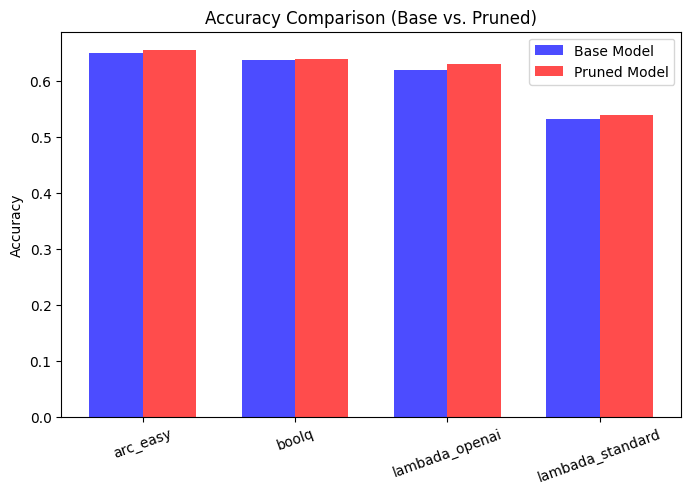

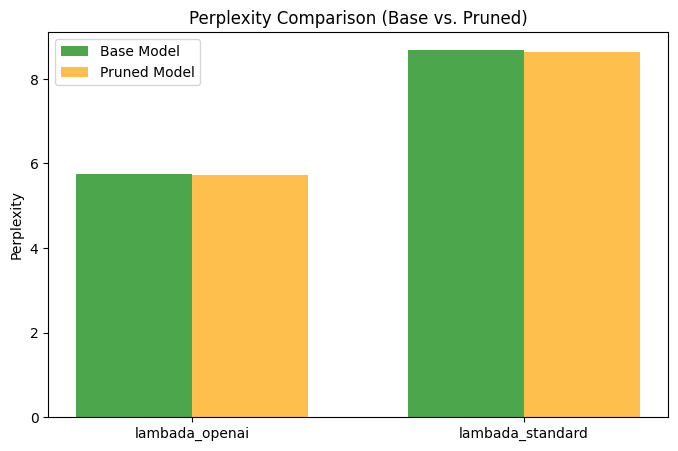

In [82]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_metrics(metrics_base, metrics_pruned):
    """
    Visualizes accuracy and perplexity before and after pruning.

    Parameters:
    - metrics_base: Dictionary of metrics for the base model
    - metrics_pruned: Dictionary of metrics for the pruned model
    """
    datasets = list(metrics_base.keys())

    # Extract accuracy values
    acc_base = [metrics_base[d].get('acc,none', None) for d in datasets]
    acc_pruned = [metrics_pruned[d].get('acc,none', None) for d in datasets]

    # Extract perplexity values (ignoring None values)
    datasets_ppl = [d for d in datasets if 'perplexity,none' in metrics_base[d]]
    ppl_base = [metrics_base[d]['perplexity,none'] for d in datasets_ppl]
    ppl_pruned = [metrics_pruned[d]['perplexity,none'] for d in datasets_ppl]

    # Bar Width
    bar_width = 0.35
    x = np.arange(len(datasets))

    # Plot Accuracy Comparison
    plt.figure(figsize=(8, 5))
    plt.bar(x - bar_width/2, acc_base, bar_width, label="Base Model", color='blue', alpha=0.7)
    plt.bar(x + bar_width/2, acc_pruned, bar_width, label="Pruned Model", color='red', alpha=0.7)
    plt.xticks(x, datasets, rotation=20)
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison (Base vs. Pruned)")
    plt.legend()
    plt.show()

    # Plot Perplexity Comparison (Only for relevant datasets)
    if datasets_ppl:
        x_ppl = np.arange(len(datasets_ppl))
        plt.figure(figsize=(8, 5))
        plt.bar(x_ppl - bar_width/2, ppl_base, bar_width, label="Base Model", color='green', alpha=0.7)
        plt.bar(x_ppl + bar_width/2, ppl_pruned, bar_width, label="Pruned Model", color='orange', alpha=0.7)
        plt.xticks(x_ppl, datasets_ppl)
        plt.ylabel("Perplexity")
        plt.title("Perplexity Comparison (Base vs. Pruned)")
        plt.legend()
        plt.show()

# Call the function
visualize_metrics(metrics_base, metrics_pruned)